In [53]:
from google.colab import files

uploaded = files.upload()

Saving hr_data.csv to hr_data (1).csv


In [54]:
import pandas as pd

# Load dataset
df = pd.read_csv('hr_data.csv')

# Basic exploration
print(df.head())
print(df.info())
print(df.describe())
print(df['Attrition'].value_counts())

   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...

In [55]:
# Check missing values
print(df.isnull().sum())

# Drop columns like EmployeeNumber, EmployeeCount, Over18, StandardHours if irrelevant
df.drop(['EmployeeNumber','EmployeeCount','Over18','StandardHours'], axis=1, inplace=True)

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Confirm
print(df.head())


Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [56]:
# Example: total satisfaction * years at company as a combined metric
df['Satisfaction_Years'] = df['JobSatisfaction'] * df['YearsAtCompany']


In [63]:
print(df['Attrition'].value_counts())


Attrition
0    1233
1     237
Name: count, dtype: int64


In [67]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Features and target
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Train-test split (stratify to keep distribution in test set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check new class distribution
print(pd.Series(y_train_res).value_counts())


Attrition
0    986
1    986
Name: count, dtype: int64


In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)
rf.fit(X_train_res, y_train_res)  # Use your balanced X_train_res, y_train_res

y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[216  31]
 [ 26  21]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       247
           1       0.40      0.45      0.42        47

    accuracy                           0.81       294
   macro avg       0.65      0.66      0.65       294
weighted avg       0.81      0.81      0.81       294



In [69]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Confusion Matrix:
 [[216  31]
 [ 26  21]]


                    Feature  Importance
22         StockOptionLevel    0.114734
13          JobSatisfaction    0.059239
15            MonthlyIncome    0.057640
10           JobInvolvement    0.052410
7   EnvironmentSatisfaction    0.048938
11                 JobLevel    0.048487
29     YearsWithCurrManager    0.045167
0                       Age    0.044044
27       YearsInCurrentRole    0.038459
30       Satisfaction_Years    0.036189


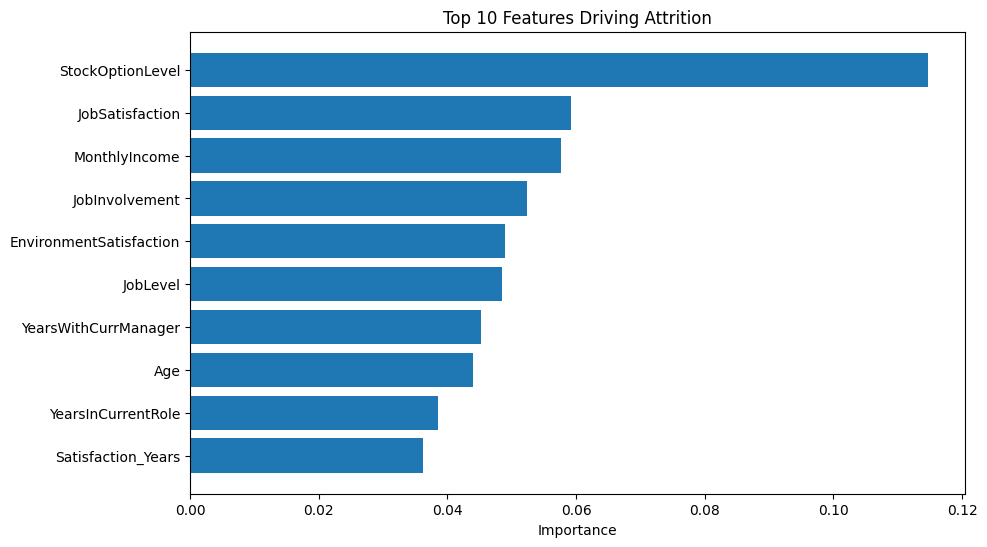

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importances
importances = rf.feature_importances_
feature_names = X_train_res.columns  # or X_train.columns if not resampled

feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Top 10 features
print(feat_imp.head(10))

# Optional: bar plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'].head(10), feat_imp['Importance'].head(10))
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 10 Features Driving Attrition")
plt.show()


In [78]:
import pandas as pd

# Your top features and importance table
feat_imp_data = {
    'Feature': [
        'StockOptionLevel', 'JobSatisfaction', 'MonthlyIncome',
        'JobInvolvement', 'EnvironmentSatisfaction'
    ],
    'Importance': [
        0.114734, 0.059239, 0.057640, 0.052410, 0.048938
    ]
}

feat_imp_df = pd.DataFrame(feat_imp_data)

# Step 1: Add a column for each top feature in your main df
for _, row in feat_imp_df.iterrows():
    feature_name = row['Feature']
    importance_value = row['Importance']
    df[feature_name + '_Importance'] = importance_value

# Optional: create a single summary column for top 5 reasons
df['Top_Attrition_Reasons'] = ", ".join(feat_imp_df['Feature'].tolist())

# Check
df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,Gender_Reason,OverTime_Reason,PerformanceRating_Reason,Department_Reason,Top_Attrition_Reasons,StockOptionLevel_Importance,JobSatisfaction_Importance,MonthlyIncome_Importance,JobInvolvement_Importance,EnvironmentSatisfaction_Importance
0,41,1,2,1102,2,1,2,1,2,0,...,0.083835,0.067186,0.047931,0.040653,"StockOptionLevel, JobSatisfaction, MonthlyInco...",0.114734,0.059239,0.05764,0.05241,0.048938
1,49,0,1,279,1,8,1,1,3,1,...,0.083835,0.067186,0.047931,0.040653,"StockOptionLevel, JobSatisfaction, MonthlyInco...",0.114734,0.059239,0.05764,0.05241,0.048938
2,37,1,2,1373,1,2,2,4,4,1,...,0.083835,0.067186,0.047931,0.040653,"StockOptionLevel, JobSatisfaction, MonthlyInco...",0.114734,0.059239,0.05764,0.05241,0.048938
3,33,0,1,1392,1,3,4,1,4,0,...,0.083835,0.067186,0.047931,0.040653,"StockOptionLevel, JobSatisfaction, MonthlyInco...",0.114734,0.059239,0.05764,0.05241,0.048938
4,27,0,2,591,1,2,1,3,1,1,...,0.083835,0.067186,0.047931,0.040653,"StockOptionLevel, JobSatisfaction, MonthlyInco...",0.114734,0.059239,0.05764,0.05241,0.048938


In [81]:
# Columns to keep in employee-level table
employee_cols = [
    'Attrition',
    'Age',
    'Department',
    'JobRole',
    'MonthlyIncome',
    'YearsAtCompany',
    'Top_Attrition_Reasons'  # optional summary for tooltip
]

df_employee = df[employee_cols].copy()

# Check the result
df_employee.head()


,Attrition,Age,Department,JobRole,MonthlyIncome,YearsAtCompany,Top_Attrition_Reasons
0,1,41,2,7,5993,6,"StockOptionLevel, JobSatisfaction, MonthlyInco..."
1,0,49,1,6,5130,10,"StockOptionLevel, JobSatisfaction, MonthlyInco..."
2,1,37,1,2,2090,0,"StockOptionLevel, JobSatisfaction, MonthlyInco..."
3,0,33,1,6,2909,8,"StockOptionLevel, JobSatisfaction, MonthlyInco..."
4,0,27,1,2,3468,2,"StockOptionLevel, JobSatisfaction, MonthlyInco..."


In [82]:
import pandas as pd

# Top 5 features and their normalized importance
top_features = [
    ('StockOptionLevel', 0.114734),
    ('JobSatisfaction', 0.059239),
    ('MonthlyIncome', 0.057640),
    ('JobInvolvement', 0.052410),
    ('EnvironmentSatisfaction', 0.048938)
]

# Create DataFrame
df_top_reasons = pd.DataFrame(top_features, columns=['Feature', 'Importance'])

# Sort descending
df_top_reasons = df_top_reasons.sort_values(by='Importance', ascending=False)

# Check
df_top_reasons


,Feature,Importance
0,StockOptionLevel,0.114734
1,JobSatisfaction,0.059239
2,MonthlyIncome,0.057640
3,JobInvolvement,0.052410
4,EnvironmentSatisfaction,0.048938


In [83]:
df_employee.to_csv('employee_dashboard.csv', index=False)
df_top_reasons.to_csv('top_reasons_dashboard.csv', index=False)


In [84]:
from google.colab import files

files.download("employee_dashboard.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
files.download("top_reasons_dashboard.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>